Usig tweakwcs:  
https://github.com/spacetelescope/tweakwcs/blob/master/notebooks/align_fits_wcs.ipynb

In [24]:
import tweakwcs
from tweakwcs import fit_wcs, align_wcs, FITSWCS, TPMatch, WCSImageCatalog
from stwcs.wcsutil import HSTWCS
from drizzlepac import updatehdr
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import os

In [46]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm

In [47]:
# Input HST image to be tweaked to reference image
input_image_dir = '/Users/dcoe/JWST/ERO/cluster/10/images/'
input_image = 'hlsp_relics_hst_acs-wfc3-60mas_smacs0723-73_total_v1_drz.fits'
input_image = os.path.join(input_image_dir, input_image)
input_hdu_list = fits.open(input_image)
input_idata = 0
input_wcs = HSTWCS(input_hdu_list, input_idata)
input_data = input_hdu_list[input_idata].data

input_catalog_file = 'hlsp_relics_hst_acs-wfc3ir_smacs0723-73_multi_v1_cat.txt'
input_catalog_file = 'hst_coords_stars.txt'  # 92 stars from Alaina
input_catalog = ascii.read(input_catalog_file)
#input_catalog.rename_column('RA',  'RA')
input_catalog.rename_column('Dec', 'DEC')
input_coordinates = SkyCoord(ra=input_catalog['RA']*u.deg, dec=input_catalog['DEC']*u.deg)
input_catalog['x'], input_catalog['y'] = input_wcs.world_to_pixel(input_coordinates)
print(input_catalog.columns)
#input_catalog
input_wcs

<TableColumns names=('RA','DEC','x','y')>


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 110.8334902931617  -73.45420265962855  
CRPIX : 2500.0  2500.0  
CD1_1 CD1_2  : -1.6666666666666e-05  0.0  
CD2_1 CD2_2  : 0.0  1.66666666666666e-05  
NAXIS : 5000  5000

In [48]:
# Reference JWST catalog
reference_image_dir = '../images'
reference_image = 'ero10_smacs0723_cluster_f200w_drz.fits'
reference_image = os.path.join(reference_image_dir, reference_image)
reference_hdu_list = fits.open(reference_image)
reference_wcs = HSTWCS(reference_hdu_list, 0)

#reference_image = 'macs0647-f444w_drz_sci.fits'
#reference_catalog_file = '../phot/ero10_f200w_detections.ecsv'
reference_catalog_file = 'jwst_coords_stars.txt'  # 92 stars from Alaina nc_coords
reference_catalog = ascii.read(reference_catalog_file)
#reference_catalog.rename_column('RA',  'RA')
reference_catalog.rename_column('Dec', 'DEC')
reference_coordinates = SkyCoord(ra=reference_catalog['RA']*u.deg, dec=reference_catalog['DEC']*u.deg)
reference_catalog['x'], reference_catalog['y'] = reference_wcs.world_to_pixel(reference_coordinates)
print(reference_catalog.columns)
#reference_catalog
reference_wcs

<TableColumns names=('RA','DEC','x','y')>


Set DATE-AVG to '2022-06-07T06:27:17.250' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915145 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662439.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 110.8261940446365  -73.45398878295636  
CRPIX : 3501.5  3501.5  
PC1_1 PC1_2  : -1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 8.33333333333333e-06  8.33333333333333e-06  
NAXIS : 7000  7000

In [117]:
# Match sources in the catalogs:
# https://tweakwcs.readthedocs.io/en/stable/matchutils.html
#match = TPMatch(searchrad=5, separation=0.1, tolerance=5, use2dhist=False)
match = TPMatch(searchrad=6, separation=3, tolerance=2, use2dhist=True)
input_wcs_corrector = FITSWCS(input_wcs)
ridx, iidx = match(reference_catalog, input_catalog, input_wcs_corrector)
len(ridx), len(iidx)

(28, 28)

In [147]:
# Match sources in the catalogs:
# https://tweakwcs.readthedocs.io/en/stable/matchutils.html
#match = TPMatch(searchrad=5, separation=0.1, tolerance=5, use2dhist=False)
#match = TPMatch(searchrad=6, separation=3, tolerance=2, use2dhist=True)
match = TPMatch(searchrad=20, separation=3, tolerance=3, use2dhist=False, xoffset=2, yoffset=5)
input_wcs_corrector = FITSWCS(input_wcs)
ridx, iidx = match(reference_catalog, input_catalog, input_wcs_corrector)
len(ridx), len(iidx)

(60, 60)

<IPython.core.display.Javascript object>


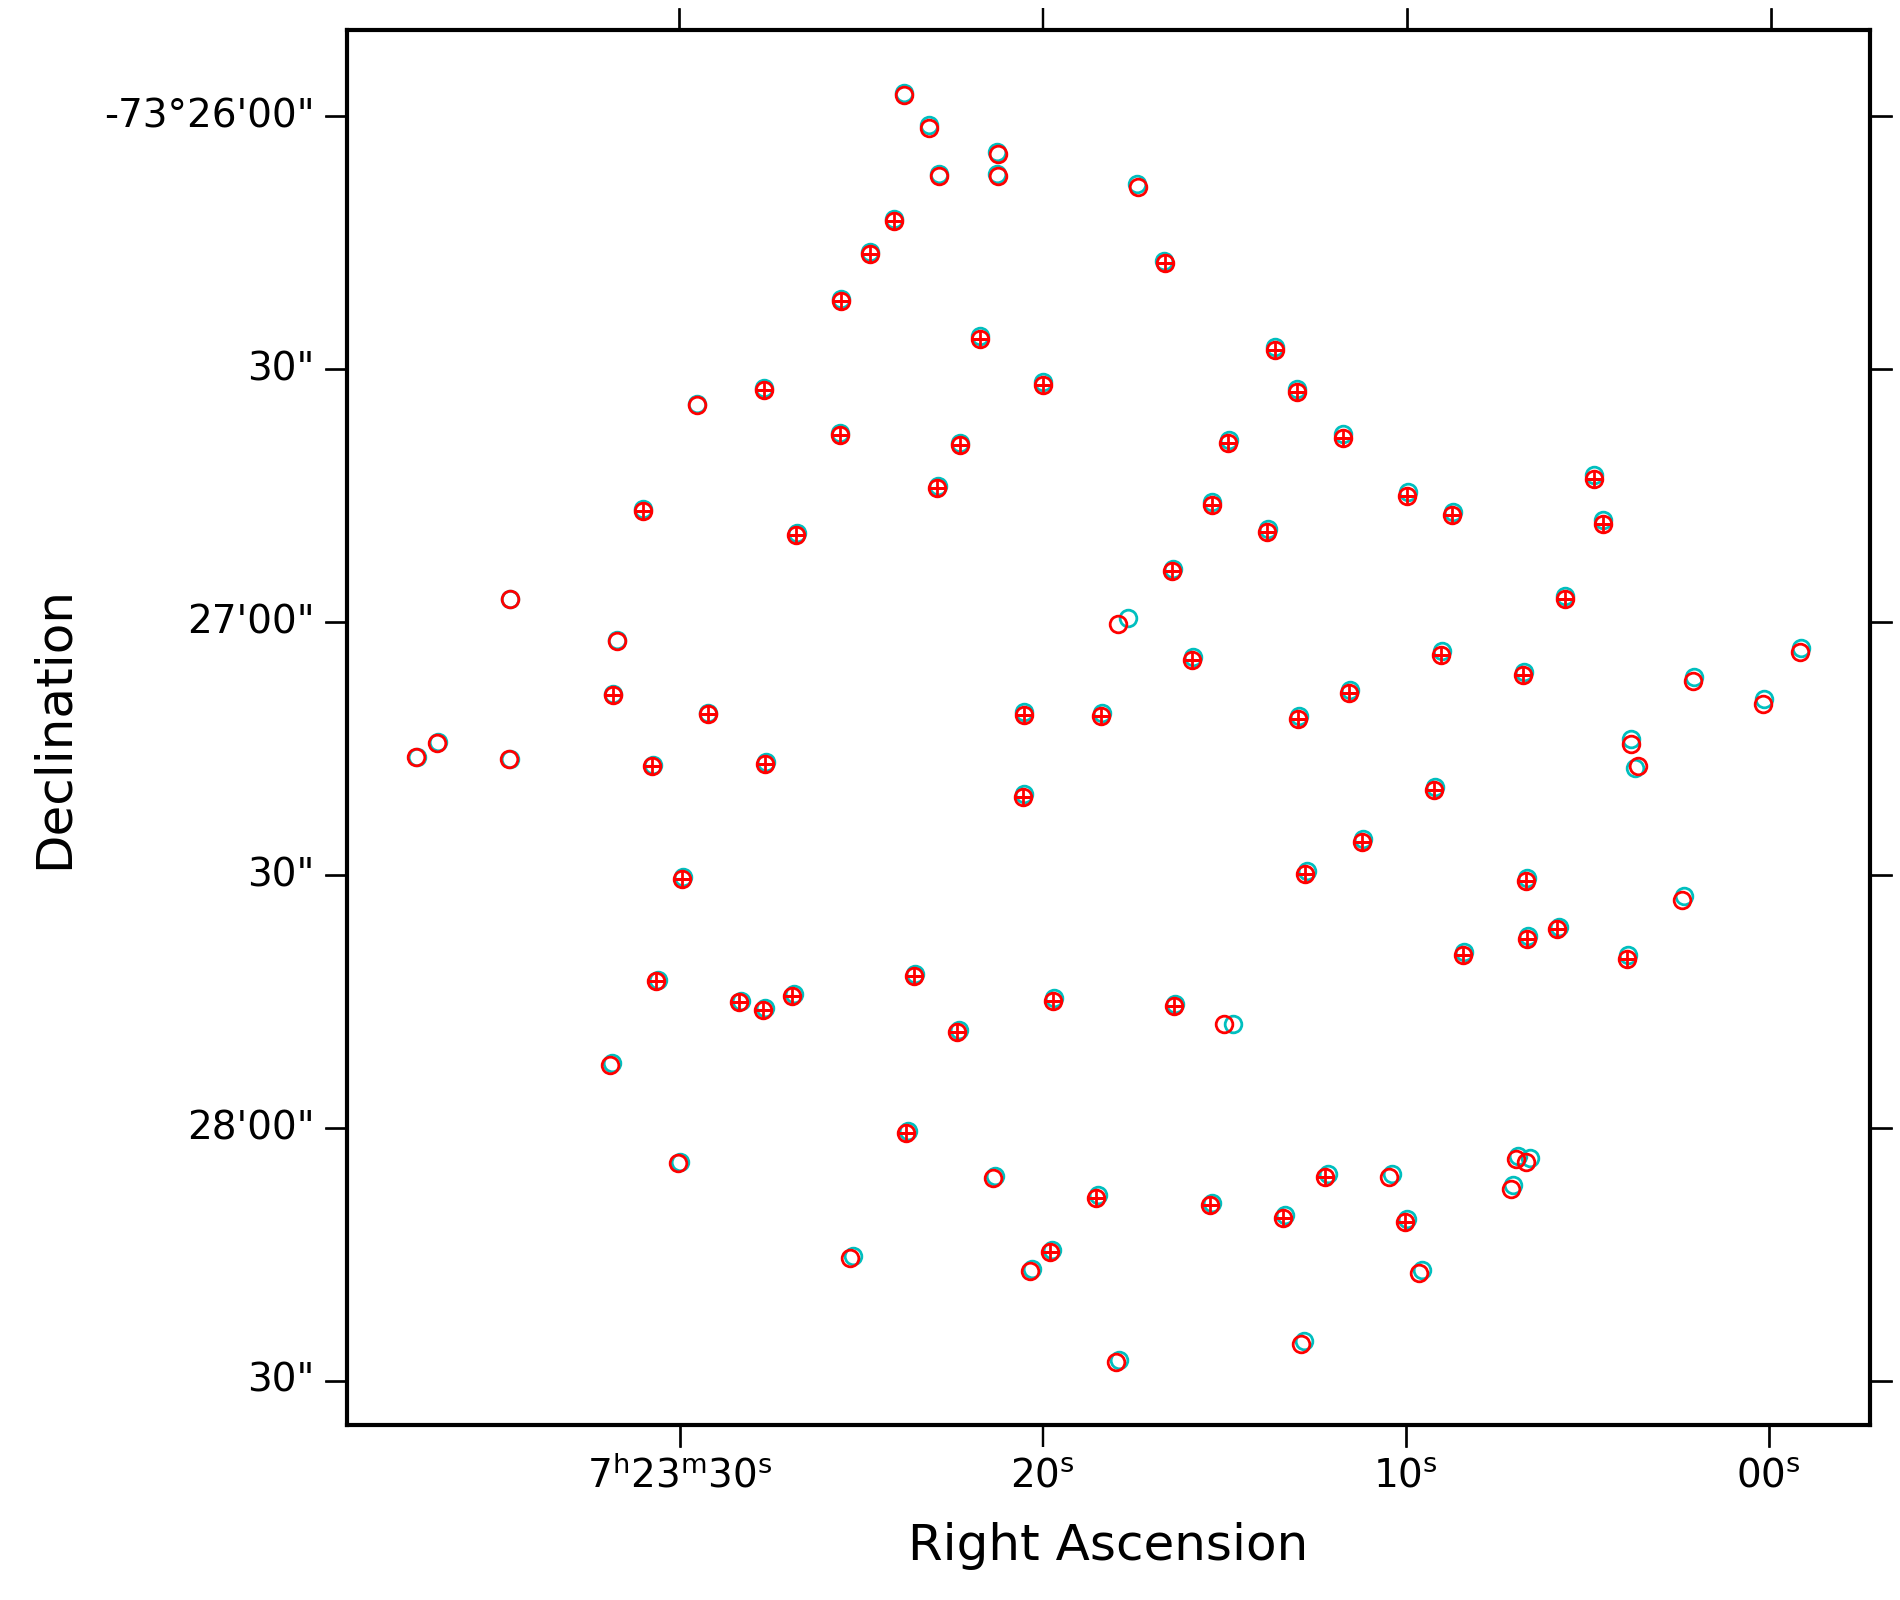

In [148]:
fig = plt.figure(figsize=(9.5, 8))
ax = fig.add_subplot(1, 1, 1, projection=input_wcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
#plt.imshow(input_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(input_catalog['RA'], input_catalog['DEC'], 'co', mfc='None', transform=ax.get_transform('world'))
plt.plot(reference_catalog['RA'], reference_catalog['DEC'], 'ro', mfc='None', transform=ax.get_transform('world'))
plt.plot(reference_catalog['RA'][ridx], reference_catalog['DEC'][ridx], 'r+', mfc='None', transform=ax.get_transform('world'))

In [151]:
# Align image WCS:
#aligned_imwcs = fit_wcs(input_catalog[ridx], reference_catalog[iidx], wcs_corrector).wcs
aligned_imwcs = fit_wcs(reference_catalog[ridx], input_catalog[iidx], wcs_corrector).wcs
aligned_imwcs
#input_catalog.meta['aligned_wcs'] = aligned_imwcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 110.83360711831327  -73.45428045006769  
CRPIX : 2500.0  2500.0  
CD1_1 CD1_2  : -1.66641535887547e-05  -4.599521547159328e-08  
CD2_1 CD2_2  : -4.451885235200573e-08  1.666264021175339e-05  
NAXIS : 5000  5000

In [154]:
# https://drizzlepac.readthedocs.io/en/latest/updatehdr.html
updatehdr.update_wcs(input_hdu_list, input_idata, aligned_imwcs, wcsname='TWEAK', reusename=True, verbose=True)

Updating header for /Users/dcoe/JWST/ERO/cluster/10/images/hlsp_relics_hst_acs-wfc3-60mas_smacs0723-73_total_v1_drz.fits[0]
WCS Keywords

CD_11  CD_12: -1.66641535887547e-05 -4.599521547159328e-08
CD_21  CD_22: -4.451885235200573e-08 1.666264021175339e-05
CRVAL    : 110.83360711831327 -73.45428045006769
CRPIX    : 2500.0 2500.0
NAXIS    : 5000 5000
Plate Scale : 0.0599999999999976
ORIENTAT : -0.15815771074578766
WCSNAME  :  TWEAK


In [156]:
input_image_aligned_to_reference = 'ero10_acs-wfc3_aligned_to_nircam.fits'
input_hdu_list.writeto(input_image_aligned_to_reference, overwrite=True)